In [2]:
import numpy as np
import h5py
import os
import csv
import time
from torch import manual_seed
import h5py
from torch.utils.data import random_split
import pandas as pd

In [3]:
import ecg_plot

p = "./HDF5_DATA/Code15/Code15_ECG.hdf5"
with h5py.File(p, "r") as file:
    x = file['ECG'][:1]
    

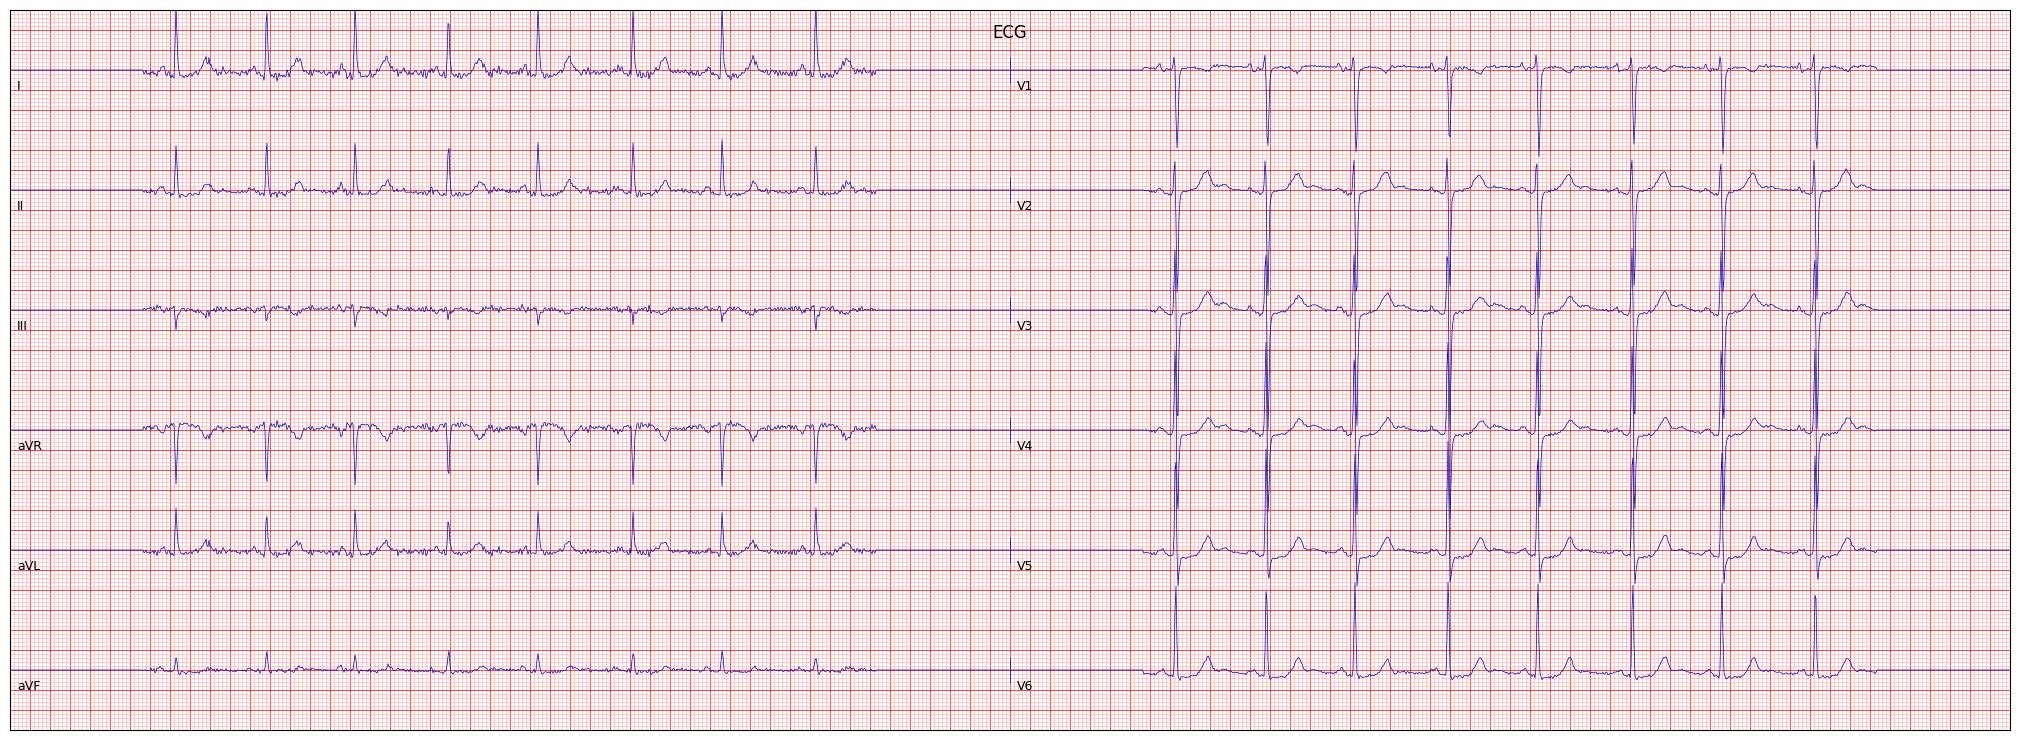

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os
from math import ceil 

lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

def plot(
        ecg, 
        sample_rate    = 500, 
        title          = 'ECG 12', 
        lead_index     = lead_index, 
        lead_order     = None,
        style          = None,
        columns        = 2,
        row_height     = 6,
        show_lead_name = True,
        show_grid      = True,
        show_separate_line  = True,
        ):
    """Plot multi lead ECG chart.
    # Arguments
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        sample_rate: Sample rate of the signal.
        title      : Title which will be shown on top off chart
        lead_index : Lead name array in the same order of ecg, will be shown on 
            left of signal plot, defaults to ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        lead_order : Lead display order 
        columns    : display columns, defaults to 2
        style      : display style, defaults to None, can be 'bw' which means black white
        row_height :   how many grid should a lead signal have,
        show_lead_name : show lead name
        show_grid      : show grid
        show_separate_line  : show separate line
    """

    if not lead_order:
        lead_order = list(range(0,len(ecg)))
    secs  = len(ecg[0])/sample_rate
    leads = len(lead_order)
    rows  = int(ceil(leads/columns))
    # display_factor = 2.5
    display_factor = 1
    line_width = 0.5
    fig, ax = plt.subplots(figsize=(secs*columns * display_factor, rows * row_height / 5 * display_factor))
    ax.tick_params(
        axis='both',       # affect both x and y
        which='both',      # major and minor ticks
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False
    )
    display_factor = display_factor ** 0.5
    fig.subplots_adjust(
        hspace = 0, 
        wspace = 0,
        left   = 0,  # the left side of the subplots of the figure
        right  = 1,  # the right side of the subplots of the figure
        bottom = 0,  # the bottom of the subplots of the figure
        top    = 1
        )

    fig.suptitle(title)

    x_min = 0
    x_max = columns*secs
    y_min = row_height/4 - (rows/2)*row_height
    y_max = row_height/4

    if (style == 'bw'):
        color_major = (0.4,0.4,0.4)
        color_minor = (0.75, 0.75, 0.75)
        color_line  = (0,0,0)
    else:
        color_major = (1,0,0)
        color_minor = (1, 0.7, 0.7)
        color_line  = (0,0,0.7)

    if(show_grid):
        ax.set_xticks(np.arange(x_min,x_max,0.2))    
        ax.set_yticks(np.arange(y_min,y_max,0.5))

        ax.minorticks_on()
        
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))

        ax.grid(which='major', linestyle='-', linewidth=0.5 * display_factor, color=color_major)
        ax.grid(which='minor', linestyle='-', linewidth=0.5 * display_factor, color=color_minor)

    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)


    for c in range(0, columns):
        for i in range(0, rows):
            if (c * rows + i < leads):
                y_offset = -(row_height/2) * ceil(i%rows)
                # if (y_offset < -5):
                #     y_offset = y_offset + 0.25

                x_offset = 0
                if(c > 0):
                    x_offset = secs * c
                    if(show_separate_line):
                        ax.plot([x_offset, x_offset], [ecg[t_lead][0] + y_offset - 0.3, ecg[t_lead][0] + y_offset + 0.3], linewidth=line_width * display_factor, color=color_line)

         
                t_lead = lead_order[c * rows + i]
         
                step = 1.0/sample_rate
                if(show_lead_name):
                    ax.text(x_offset + 0.07, y_offset - 0.5, lead_index[t_lead], fontsize=9 * display_factor)
                ax.plot(
                    np.arange(0, len(ecg[t_lead])*step, step) + x_offset, 
                    ecg[t_lead] + y_offset,
                    linewidth=line_width * display_factor, 
                    color=color_line
                    )

plot(np.transpose(x[0]), sample_rate=100, title = 'ECG', show_grid=True)
# ecg_plot.save_as_png("ecg_plot", "./")

In [9]:
for f in os.listdir("/home/dang.nh4/ecg-survival-benchmark/HDF5_DATA/Code15"):
    if "imagessid" in f:
        os.remove(os.path.join("/home/dang.nh4/ecg-survival-benchmark/HDF5_DATA/Code15", f))

In [8]:
plot(np.transpose(x[0]), sample_rate=100, title = 'ECG', show_grid=True)
ecg_plot.save_as_png("ecg_plot", "./")

In [4]:
import wfdb
import shutil

INPUT_SHAPE = (12, 1000)

FS = 100 
OUTPUT_DIR = "./code15_output"
TEMP_DATA_DIR = "temp_data"

os.makedirs(TEMP_DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Generating dummy signal of shape {INPUT_SHAPE}...")
ecg_signal = np.random.randn(INPUT_SHAPE[1], INPUT_SHAPE[0]) 

record_name = "test_record"
record_path = os.path.join(TEMP_DATA_DIR, record_name)

lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

print("Saving temporary WFDB record...")
wfdb.wrsamp(
    record_name=record_name,
    fs=FS,
    units=['mV'] * 12,
    sig_name=lead_names,
    p_signal=ecg_signal,
    fmt=['16'] * 12,
    write_dir=TEMP_DATA_DIR
)



Generating dummy signal of shape (12, 1000)...
Saving temporary WFDB record...


In [14]:
code15_exams_dir = os.path.join(data_dir,'exams.csv')  
new_data_path = os.path.join(data_dir, 'Labels_Code15_mort_032025_pd_8020.csv') 

labels = pd.read_csv(new_data_path)

In [16]:
len(sids)

325779

In [15]:
labels[labels['SID']==272614]

,Unnamed: 0,SID,Age,Is_Male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,PID,Mort_Event,Mort_TTE,normal_ecg,trace_file,train_test_split
73748,73748,272614,65,False,39.086166,False,False,False,False,False,False,852024,False,4.035613,True,exams_part12.hdf5,train


In [8]:
for sid in sids:
    if sid == 1576698:
        print("Found SID 272614")

Found SID 272614


In [31]:
os.path.split("./dang/file.txt")
# os.path.splitext("./dang/file.txt")

('./dang', 'file.txt')

In [20]:
p = "./HDF5_DATA/Code15/Code15_ECG.hdf5"
with h5py.File(p, "r") as file:
    x = file['ECG'][:3]

In [26]:
x.reshape(x.shape[0], 12, -1).shape

(3, 12, 1000)

In [17]:
header = """00001_lr 12 100 1000
00001_lr.dat 16 1000.0(0)/mV 16 0 -119 1508 0 I
00001_lr.dat 16 1000.0(0)/mV 16 0 -55 723 0 II
00001_lr.dat 16 1000.0(0)/mV 16 0 64 64758 0 III
00001_lr.dat 16 1000.0(0)/mV 16 0 86 64423 0 AVR
00001_lr.dat 16 1000.0(0)/mV 16 0 -91 1211 0 AVL
00001_lr.dat 16 1000.0(0)/mV 16 0 4 7 0 AVF
00001_lr.dat 16 1000.0(0)/mV 16 0 -69 63827 0 V1
00001_lr.dat 16 1000.0(0)/mV 16 0 -31 6999 0 V2
00001_lr.dat 16 1000.0(0)/mV 16 0 0 63759 0 V3
00001_lr.dat 16 1000.0(0)/mV 16 0 -26 61447 0 V4
00001_lr.dat 16 1000.0(0)/mV 16 0 -39 64979 0 V5
00001_lr.dat 16 1000.0(0)/mV 16 0 -79 832 0 V6"""

leads = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

import numpy as np

def get_adc_gains(header, leads):
    adc_gains = np.zeros(len(leads))
    for i, l in enumerate(header.split('\n')):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            current_lead = entries[-1]
            if current_lead in leads:
                j = leads.index(current_lead)
                try:
                    print(entries[2].split('/')[0])
                    # adc_gains[j] = float(entries[2].split('/')[0])
                except:
                    pass
        else:
            break
    return adc_gains

get_adc_gains(header, leads)

1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)
1000.0(0)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# ---------------------------------------
# 1. Create a binary classification dataset
# ---------------------------------------
X, y = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=5,
    n_redundant=2,
    weights=[0.9, 0.1],      # imbalanced dataset
    random_state=42
)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# ---------------------------------------
# 2. Train a classifier
# ---------------------------------------
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

# ---------------------------------------
# 3. Predict probabilities
# ---------------------------------------
y_prob = clf.predict_proba(X_test)[:, 1]  # probability of positive class

# AUROC
auroc = roc_auc_score(y_test, y_prob)

# AUPRC (Average Precision)
auprc = average_precision_score(y_test, y_prob)

# ---------------------------------------
# 5. Print results
# ---------------------------------------
print(f"AUROC: {auroc:.4f}")
print(f"AUPRC: {auprc:.4f}")

# Optional: check baseline PR (positive prevalence)
baseline_auprc = np.mean(y_test)
print(f"Baseline AUPRC (positive prevalence): {baseline_auprc:.4f}")


AUROC: 0.8588
AUPRC: 0.5258
Baseline AUPRC (positive prevalence): 0.1033


In [10]:
y_prob
# y_test

array([0.15291125, 0.0039218 , 0.10668613, ..., 0.30721057, 0.1771515 ,
       0.06811176], shape=(1500,))

In [5]:
X.shape
y.shape

(5000,)

In [9]:
path = "./script/Trained_Models/Code15/ECGTransForm/EVAL/Code15 Test_Folder/Stored_Model_Output.hdf5"
x = {}
with h5py.File(path, "r") as f:
    for key in f.keys():
        x[key] = f[key][()]

In [36]:
x['sample_time_points'][65]

np.float64(5.036664191919192)

In [38]:
x['concordance_store_all_ecg'][13]

np.float64(0.7792775336208247)

In [35]:
x["AUPRC"][65]

np.float64(0.1292698492678316)

In [23]:
for i in range(100):
    if x["AUROC"][i] != -1:
        print(i)

13
26
65
99


In [101]:
x = pd.read_csv("/mnt/disk1/aiotlab/dangnh/ecg-survival-benchmark/HDF5_DATA/Code15/Labels_Code15_mort_032025_pd_8020.csv")

In [ ]:
train_ecg_path = "/mnt/disk1/aiotlab/dangnh/ecg-survival-benchmark/HDF5_DATA/Code15/Code15_ECG.hdf5"
y = {}

with h5py.File(train_ecg_path, "r") as f:
    tmp = x[x['train_test_split']=="train"]
    ECG_SID_Row  = {SID:i for i,SID in enumerate(f['SID'])} # Which ECG.h5 row corresponds to which SID?
    rows_to_pull = np.array([ECG_SID_Row[SID] for SID in tmp['SID']])
    y['ecg'] = f["ECG"][np.sort(rows_to_pull)]
    # print(f.keys())
    # print(f['ECG'].shape)
    # y["ecg"] = f['ECG'][:] # 20000
    # y['pid'] = f['PID'][:]
    # y['sid'] = f['SID'][:]

In [136]:
from pycox.models import LogisticHazard

tmp = x[x['train_test_split']=="train"]
max_duration = max(tmp['Mort_TTE'])
labtrans = LogisticHazard.label_transform(100)
idx_durations, events = labtrans.fit_transform(np.array([0,max_duration]), np.array([0,1]))

a,b = labtrans.transform(tmp['Mort_TTE'].to_numpy(),tmp['Mort_Event'].astype(int).to_numpy())
tmp['Disc_TTE'] = a

/tmp/ipykernel_3665247/1876571392.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Disc_TTE'] = a


In [93]:
tmp['Mort_Event'].astype(int).to_numpy()

array([0, 0, 0, ..., 0, 0, 0], shape=(11380,))

In [ ]:
np.array([0.01])

(1,)

In [132]:
z = np.array([1, 2, 3, 4])
z[np.array([False, True, True, False])]

array([2, 3])

In [137]:
labtrans.transform(np.array([7.61, 0.01]), np.array([1, 0]))

(array([99,  0]), array([1., 0.], dtype=float32))

In [4]:
import os
os.path.dirname(os.getcwd())

import torch
torch.cuda.get_rng_state()

tensor([123, 209,  26, 115, 157, 218,  21,   0,   0,   0,   0,   0,   0,   0,
          0,   0], dtype=torch.uint8)

In [66]:
tmp

,Unnamed: 0,index,SID,Age,Is_Male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,PID,Mort_Event,Mort_TTE,normal_ecg,trace_file,train_test_split,Disc_TTE
3,3,355,2660251,42,False,48.175446,False,False,False,False,False,False,160919,False,7.243830,False,exams_part0.hdf5,train,93
5,5,357,1047116,73,True,75.276790,False,False,False,False,False,False,699142,False,2.334245,False,exams_part0.hdf5,train,30
6,6,358,411184,82,False,93.824820,False,False,False,False,False,False,1687284,False,3.723285,False,exams_part0.hdf5,train,48
10,10,362,1278551,82,False,79.989070,False,False,False,False,False,False,1517732,False,1.901368,False,exams_part0.hdf5,train,24
13,13,365,2905463,19,False,27.834717,False,False,False,False,False,False,1493110,False,6.564378,False,exams_part0.hdf5,train,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19992,19992,344088,254925,46,True,52.909176,False,False,False,False,False,False,1090352,False,4.073969,True,exams_part0.hdf5,train,52
19994,19994,344090,433358,27,False,46.071053,False,False,False,False,False,False,649876,False,3.638353,False,exams_part0.hdf5,train,46
19997,19997,344093,1439610,37,False,37.154194,False,False,False,False,False,False,231567,False,1.545204,True,exams_part0.hdf5,train,19
19998,19998,344094,3096455,74,True,76.501396,False,False,False,False,False,False,611873,False,6.589036,False,exams_part0.hdf5,train,84


In [63]:
len(labtrans.cuts)
labtrans.idu

In [8]:
x['Mort_Event']=x['Mort_Event'].values.astype(bool)
x

,Unnamed: 0,index,SID,Age,Is_Male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,PID,Mort_Event,Mort_TTE,normal_ecg,trace_file,train_test_split
0,0,352,3158243,59,False,64.235565,False,False,False,False,False,False,1280570,True,NaN,False,exams_part0.hdf5,NegTTE
1,1,353,1126697,63,False,67.575520,False,False,False,False,False,False,223781,False,2.178080,True,exams_part0.hdf5,test
2,2,354,91288,49,False,55.587772,False,False,False,False,False,False,1546425,True,NaN,False,exams_part0.hdf5,NegTTE
3,3,355,2660251,42,False,48.175446,False,False,False,False,False,False,160919,False,7.243830,False,exams_part0.hdf5,train
4,4,356,4390974,42,True,47.617800,False,False,False,False,False,False,98649,True,NaN,False,exams_part0.hdf5,NegTTE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,344091,1133183,46,False,61.897950,False,False,False,False,False,False,161647,True,NaN,True,exams_part0.hdf5,NegTTE
19996,19996,344092,531004,71,True,78.271890,False,False,False,False,False,False,110931,True,NaN,False,exams_part0.hdf5,NegTTE
19997,19997,344093,1439610,37,False,37.154194,False,False,False,False,False,False,231567,False,1.545204,True,exams_part0.hdf5,train
19998,19998,344094,3096455,74,True,76.501396,False,False,False,False,False,False,611873,False,6.589036,False,exams_part0.hdf5,train


In [25]:
import h5py

path = "./Trained_Models/Code15/InceptionTime/EVAL/Code15 Test_Folder/Stored_Model_Output.hdf5"
with h5py.File(path, "r") as f:
    auroc = f["AUROC"][()]
    auprc = f["AUPRC"][()]
    concordance = f["concordance_store_all_ecg"][()]
    time_points = f["sample_time_points"][()]
    surv = f["surv"][()]

In [26]:
sum(concordance[concordance != -1])/4

np.float64(0.7752678419432851)

In [13]:
import h5py
from scipy.signal import resample

code15_ecg_dir = "/mnt/disk1/aiotlab/dangnh/ecg-survival-benchmark/HDF5_DATA/Code15/Code15_ECG.hdf5"

with h5py.File(code15_ecg_dir, "r") as h:
    # print(h['tracings'][:2].shape)
    # y = resample(h['tracings'][:1], 1000, axis = 1)
    # x.append(y)
    # x = h['SID'][()]
    ECGs = resample(h['ECG'][()], 1000, axis = 1)
    EIDs = h['SID'][()]
    labels = h['PID'][()]


In [14]:
tmp = "/mnt/disk1/aiotlab/dangnh/ecg-survival-benchmark/HDF5_DATA/Code15/100hz_Code15_ECG.hdf5"

with h5py.File(tmp, "w") as f:
    f.create_dataset('ECG',       data = ECGs, chunks = (1,1000,12),  compression="gzip")
    f.create_dataset('SID',       data = EIDs)
    f.create_dataset('PID',       data = labels)